<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Mounted at /content/drive
Runtime switched to GPU
GPU device not found
Please install GPU version of TF


In [2]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning the Data

In [3]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Encoding

### Create the Category Column

In [4]:
# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Type
df['Type'] = le.fit_transform(df['Type'])

# Delivery Status
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])

# Category Name
df['Category Name'] = le.fit_transform(df['Category Name'])

# Department Name
df['Department Name'] = le.fit_transform(df['Department Name'])

# Market
df['Market'] = le.fit_transform(df['Market'])

# Order Status
df['Order Status'] = le.fit_transform(df['Order Status'])

# Shipping Mode
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])

# Customer Segment
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])

# Category
df['Category'] = le.fit_transform(df['Category'])

# Customer City
df['Customer City'] = le.fit_transform(df['Customer City'])

# Order City
df['Order City'] = le.fit_transform(df['Order City'])

# Product Name
df['Product Name'] = le.fit_transform(df['Product Name'])

# Order Region
df['Order Region'] = le.fit_transform(df['Order Region'])

# Prediction

## Split the Data

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)'], axis = 1)
y = df['Days for shipping (real)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Encode the remaining columns after the split

In [7]:
!pip install category_encoders
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['Order State'])

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 6.1 MB/s eta 0:00:00


## Choosing the Model

In [8]:
from sklearn.linear_model import LinearRegression

# Initialize linear regression model
model = LinearRegression()

# Mean squared error: 0.53

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
model = RandomForestRegressor(n_estimators=100)

# Mean squared error: 0.10

## Performance of the Model

In [ ]:
from sklearn.metrics import mean_squared_error
import pickle

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/lr.pkl', 'wb') as file:
    pickle.dump(model, file)

### Over 20 Splits

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd
import numpy as np
#!pip install category_encoders
import category_encoders as ce

within_threshold_mean = []

threshold = 0.5

results_lr = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'Within Threshold Mean', 'Within Threshold Std'])

mse = []

# Test the model

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
    model = pickle.load(f)

# Use the trained model to make predictions on the testing data
y_pred = model.predict(X_test)

# Print the mean squared error
print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred), "\n")

# See if the model is good
residuals = y_test - y_pred

for i in range(1, 21):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  encoder = ce.TargetEncoder(cols=['Order State'])

  X_train = encoder.fit_transform(X_train, y_train)
  X_test = encoder.transform(X_test)

  y_pred = model.predict(X_test)
    
  mse.append(mean_squared_error(y_test, y_pred))

  # Calculate the percentage of predictions within the threshold value

  within_threshold_mean.append(sum(abs(y_pred - y_test) <= threshold) / len(y_pred))

print(f'MSE Mean: {np.mean(mse)}')
print(f'MSE Std: {np.std(mse)}')
print(f'Within Threshold Mean: {np.mean(within_threshold_mean)}')
print(f'Within Threshold Std: {np.std(within_threshold_mean)}')

Mean squared error: 0.09880 

MSE Mean: 0.09743783902060713
MSE Std: 0.002219723250991809
Within Threshold Mean: 0.9212386439175713
Within Threshold Std: 0.001987290780422794


## Visualization

In [16]:
from sklearn.metrics import mean_squared_error

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
      model = pickle.load(f)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: " , mse, "\n")

Mean squared error:  0.09951948537558165 



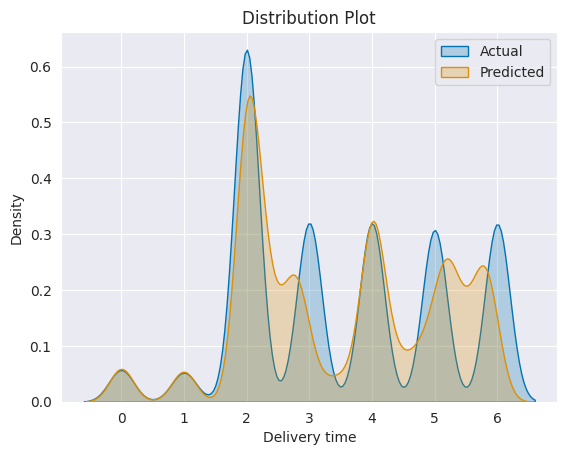

In [17]:
# Distribution plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')

# Set style for the plot
sns.set_style('darkgrid')

# Create a distribution plot
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

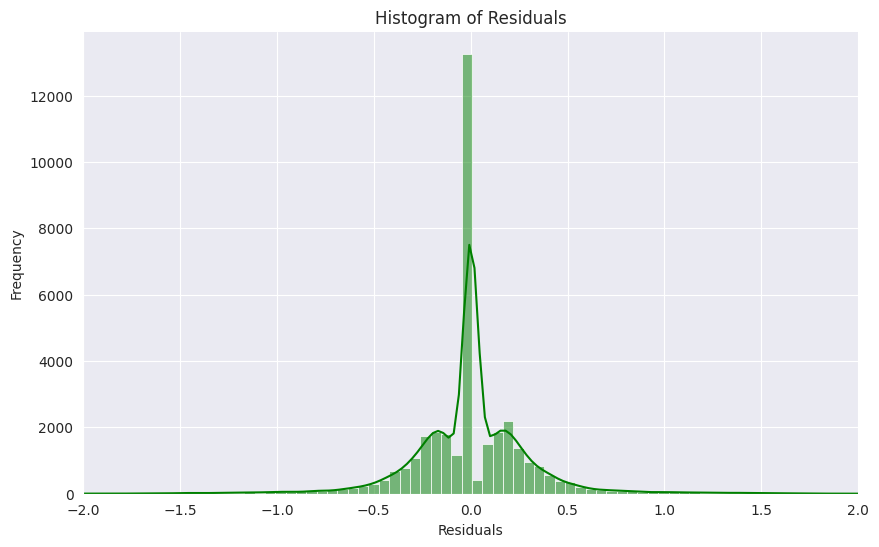

In [18]:
# Plot a histogram of the residuals

import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plot
sns.set_style('darkgrid')

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with specified number of bins and color
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)

# Set labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-2, 2))

# Remove top and right spines
sns.despine()

# Show the plot
plt.show()

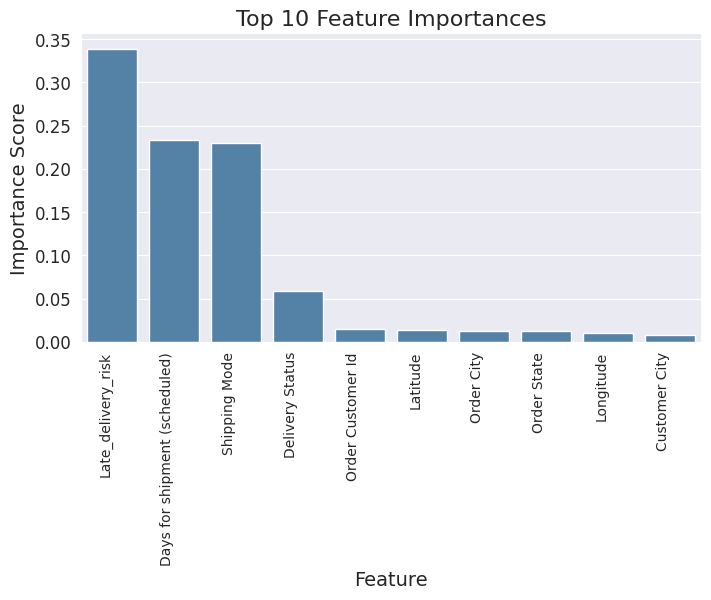

In [19]:
# Top 10 Feature Importances

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# get the feature importances
importances = model.feature_importances_

# sort the features by importance
sorted_idx = importances.argsort()[::-1]

# set style for the plot
sns.set_style('darkgrid')

# select the top 10 features
top_features = X.columns[sorted_idx][:10]
top_importances = importances[sorted_idx][:10]

# create a figure and axis objects
fig, ax = plt.subplots(figsize=(8, 4))

# create a bar chart of the top 10 features
sns.barplot(x=top_features, y=top_importances, ax=ax, color='steelblue')

# set x-axis label and rotate labels for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_xticklabels(top_features, rotation=90, ha='right', fontsize=10)

# set y-axis label and tick labels
ax.set_ylabel('Importance Score', fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# set title
ax.set_title('Top 10 Feature Importances', fontsize=16)

# remove top and right spines
sns.despine()

# show the plot
plt.show()

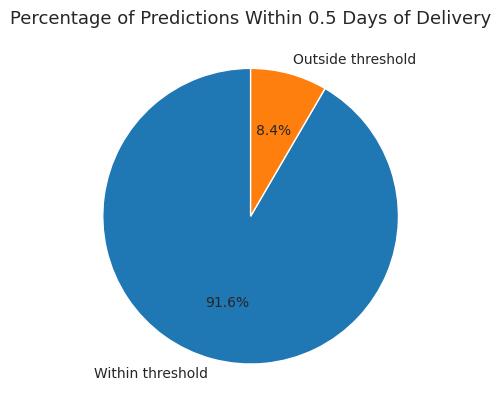

In [20]:
import matplotlib.pyplot as plt

# Set the threshold value
threshold = 0.5

# Get the predicted values
y_pred = model.predict(X_test)

# Calculate the percentage of predictions within the threshold value
within_threshold = (np.abs(y_pred - y_test) < threshold).mean()

# Calculate the percentage of predictions outside the threshold value
outside_threshold = 1 - within_threshold

# Create a pie chart
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percentage of Predictions Within 0.5 Days of Delivery', fontsize=13)

# Show the plot
plt.show()

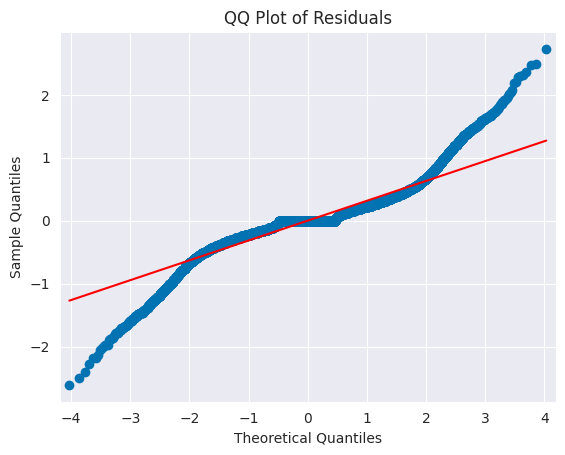

In [21]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Get the residuals
residuals = y_test - y_pred

# Create a QQ plot
qqplot(residuals, line='s')

# Add title and axis labels
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()